# Tutorial for analyzing instrumental learning data with the `HDDMnnRL` module
This is a tutorial for using the HDDMnnRL module to simultaneously estimate reinforcement learning parameters and decision parameters within a fully hierarchical bayesian estimation framework, including steps for sampling, assessing convergence, model fit, parameter recovery, and posterior predictive checks (model validation). The module uses the reinforcement learning sequential sampling model (RLSSM), a reinforcement learning model that replaces the standard “softmax” choice function with a sequential sampling process. The softmax and sequential sampling process is equivalent for capturing choice proportions, but the SSM also takes RT distributions into account. 

## OUTLINE ***
[1. Background](#1.-Background) <br>
[2. Installing the module](#2.-Installing-the-module) <br>
[3. How the RLDDM works](#3.-How-the-RLDDM-works) <br>
[4. Structuring data](#4.-Structuring-data) <br>
[5. Running basic model](#5.-Running-basic-model) <br>
[6. Checking results](#6.-Checking-results) <br>
[7. Posterior predictive checks](#7.-Posterior-predictive-checks)<br>
[8. Parameter recovery](#8.-Parameter-recovery)<br>
[12. HDDMrlRegressor](#12.-HDDMrlRegressor)<br>


## 1. Introduction to Reinforcement Learning - Sequential Sampling Models (RLSSM)

Sequential sampling models (SSMs) are a powerful class of models used to summarize cognitive process dynamics underlying decision-making in various task settings. However, a large class of cognitive tasks in laboratory settings (eg. two-stage decision making tasks, grid-navigation tasks) or even otherwise, involve some sort of learning that results from the agent’s interactions with the environment. While SSMs can be used to model the decision processes, it cannot capture the learning dynamics involved in this class of tasks. Hence, reinforcement learning (RL) is a natural choice to model the learning processes in such settings. In reinforcement learning, researchers typically assume a static decision process such as a simple softmax choice rule (for probabilistic action selection), which is informed by some ‘utility’ (or ‘good-ness’) measure of taking a particular action in a given state. While reinforcement learning models can account for choice behaviors, they cannot capture the reaction time behaviors. 

To combine the strengths of sequential sampling models and reinforcement learning models, recent studies have used the drift diffusion model to jointly model choice and response time distributions during learning (for example, see [Pedersen, Frank & Biele (2017)](https://doi.org/10.3758/s13423-016-1199-y)). Such an approach allows researchers to study not only the across-trial dynamics of learning but the within-trial dynamics of choice processes, using a single model. The main idea behind these models is to allow a reinforcement learning process to drive the trial-by-trial parameters of a sequential sampling model (such as the basic drift diffusion model), to jointly capture reaction time and choice behavior in complex tasks which involve learning from feedback. As a result, RL-SSM is a much more powerful and expressive class of models. It naturally lends itself for use in computational modeling of numerous cognitive tasks where the 'learning process' informs the 'decision-making process'.

For example, in case of the two-armed bandit task, the RLSSM estimates trial-by-trial drift rate as a scaled difference in expected rewards (expected reward for upper bound alternative minus expected reward for lower bound alternative). Expected rewards are updated with a delta learning rule such as Rescorla-Wagner update rule. The main idea here is that reward-based choices can be captured by an accumulation-to-bound process where drift rate is proportional to the difference in expected reward between options, and where expected rewards subsequently are updated in a trial-by-trial basis via reinforcement learning. <br><br>
__drift rate on each trial depends on difference in expected rewards for the two alternatives (q_up and q_low):__ <br>
drift rate = (q_up - q_low) * scaling <br><br>
_where the scaling parameter describes the weight to put on the difference in q-values._<br><br>
__expected reward (q) for chosen option is updated according to delta learning rule :__ <br>
q_chosen = q_chosen + alpha * (feedback-q_chosen) <br><br>
_where alpha weights the rate of learning on each trial._<br><br>
So in principle all you need is the Wiener first passage time likelihood-function. The reason why HDDM is useful (and hence also `HDDMnnRL`) is that it automates the process of setting up and running your model, which tends to be very time consuming. 

## 2. Installing the module
The new version of HDDM (version 0.9.6) includes the LAN-based RLSSM implementation via `HDDMnnRL` and `HDDMnnRLRegressor` classes. You can install the new version of HDDM using the following command:

    pip3 install git+https://github.com/hddm-devs/hddm

Refer to [HDDM docs](https://hddm.readthedocs.io/en/latest/) for further installation instructions.

## 3. How the `HDDMnnRL` works (moving beyond the DDM)

While SSM is a much broader class of models, including model variants which move beyond 2-choice scenarios, models which exchange the noise distribution in the diffusion, models which include attractor dynamics as well as models which deal with non-constant evidence criteria, RLSSM studies have been limited by the assumptions of DDM because of methodological convenience. The main reason being that DDM offers a closed-form analytical likelihood function (required for Bayesian inference for parameter estimation) unlike other SSMs. Therefore, the studies employ standard DDM even when other models can provide a better fit. 

We can use other SSMs but the lack of analytical likelihood demands use of likelihood-free inference methods such as ABC-MCMC. These inference methods are computationally expensive (and often require elaborate skills/experience), making the parameter estimation and model comparison significantly time-comsuming and effort-taking. In order to address these limitations in RLSSM settings, we leverage recently developed [Likelihood Approximation Networks (LANs)](https://doi.org/10.7554/eLife.65074) for fast, tractable and generalizable inference. LANs are neural networks that learn approximate empirical likelihoods for arbitrary generative models (in our case, SSMs) to faciliate fast posterior sampling during the parameter estimation process. Please refer to the paper for further information on LANs.

## 4. Structuring data
The HDDMnnRL module was created to make it easier to use a broader class of sequential sampling models in conjunction with reinforcement learning, to model instrumental learning data in a variety of task settings. If you are familiar with using HDDM, it shouldn't be a big step to start using HDDMnnRL. Please refresh your memory by starting with the [tutorial for HDDM](http://ski.clps.brown.edu/hddm_docs/index.html) first (especially critical if you have not used HDDM at all). A quick review of the HDDM [LAN extension](https://hddm.readthedocs.io/en/latest/lan_tutorial.html) would also help in understanding how the [Likelihood Approximation Networks](https://elifesciences.org/articles/65074), also used by the new HDDMnnRL class, are employed for fast, tractable inference for a variety of sequential sampling models. 

Running HDDMnnRL does require a few extra steps compared to HDDM, and because the model includes increased potential for parameter colinearity  (typically learning rate and the scaling parameter on drift rate) it is even more important to assess model fit, which will be covered below. Here are the most important steps for structuring your dataframe:
1. Sort trials in ascending order within subject and condition, to ensure proper updating of expected rewards.
2. Include a column called __'split_by'__ which identifies the different task conditions (__as integers__), to ensure reward updating will work properly for each condition without mixing values learned from one trial type to another. 
3. Code the response column with [stimulus-coding] (http://ski.clps.brown.edu/hddm_docs/howto.html#code-subject-responses). Although stimulus-coding and accuracy-coding often are the same in instrumental learning it is important that the upper and lower boundaries are represented by the same alternative within a condition, because expected rewards are linked to the thresholds/boundaries.
4. __feedback__-column. This should be the reward received for the chosen option on each trial.
5. __q_init__. Adjusting initial q-values is something that can improve model fit quite a bit. To allow the user to set their own initial values we therefore require that the dataframe includes a column called q_init. The function will set all initial q-values according to the first value in q_init. So this is not the most elegant method of allowing users to set inital value for expected rewards, but it works for now.

#### Required columns in data:
* __rt__: in seconds, same as in HDDM
* __response__: 0 or 1. defines chosen stimulus, not accuracy.
* __split_by__: needs to be an integer. Split_by defines conditions (trial-types) that should have the same variables (e.g. Q values) within subject: the trials need to be split by condition to ensure proper updating of expected rewards that do not bleed over into other trial-types. (e.g. if you have stimulus A and get reward you want that updated value to impact choice only for the next stimulus A trial but not necessarily the immediate trial afterwards, which may be of a different condition) 
* __subj_idx__: same as in HDDM, but even more important here because it is used to split trials
* __feedback__: feedback on the current trial. can be any value.
* __q_init__: used to initialize expected rewards. can be any value, but an unbiased initial value should be somewhere between the minimum and and maximum reward values (e.g. 0.5 for tasks with rewards of 0 and 1).

## 5. Running basic model
To illustrate how to run the model we will use example data from the learning phase of the probabilistic selection task (PST). During the learning phase of the PST subjects choose between two  stimuli presented as Hiragana-letters (here represented as letters from the latin alphabet). There are three conditions with different probabilities of receiving reward (feedback=1) and non-reward (feedback=0). In the AB condition A is rewarded with 80% probability, B with 20%. In the CD condition C is rewarded with 70% probability and D with 30%, while in the EF condition E is rewarded with a 60% probability and F with 40%. The dataset is included in the data-folder in your installation of HDDM.

In [1]:
# import
import pandas as pd
import numpy as np
import hddm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pymc
import kabuki

sns.set(style="white")
%matplotlib inline
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

/Users/madslundpedersen/anaconda/envs/py36/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
# load data. you will find this dataset in your hddm-folder under hddm/examples/rlddm_data.csv
data = hddm.load_csv("rlddm_data.csv")
# check structure
data.head()

,subj_idx,response,cond,rt,trial,split_by,feedback,q_init
0,42,0.0,CD,1.255,1.0,1,0.0,0.5
1,42,1.0,EF,0.778,1.0,2,0.0,0.5
2,42,1.0,AB,0.647,1.0,0,1.0,0.5
3,42,1.0,AB,0.750,2.0,0,1.0,0.5
4,42,0.0,EF,0.772,2.0,2,1.0,0.5


The columns in the datafile represent: __subj_idx__ (subject id), __response__ (1=best option), __cond__ (identifies condition, but not used in model), __rt__ (in seconds), 0=worst option), __trial__ (the trial-iteration for a subject within each condition), __split_by__ (identifying condition, used for running the model), __feedback__ (whether the response given was rewarded or not), __q_init__ (the initial q-value used for the model, explained above).

In [3]:
# run the model by calling hddm.HDDMrl (instead of hddm.HDDM for normal HDDM)
m = hddm.HDDMrl(data)
# set sample and burn-in
m.sample(1500, burn=500, dbname="traces.db", db="pickle")
# print stats to get an overview of posterior distribution of estimated parameters
m.print_stats()

 [-----------------100%-----------------] 1500 of 1500 complete in 151.7 sec                    mean         std       2.5q        25q        50q        75q     97.5q       mc err
a                1.75114   0.0837255    1.59815    1.69574    1.74802    1.80376   1.92983   0.00291067
a_std            0.41232   0.0656654   0.308913   0.367279   0.405368   0.447927   0.56776   0.00289675
a_subj.3         2.00788    0.102676    1.82598    1.93802    2.00144    2.07171   2.23154   0.00493845
a_subj.4         1.89902   0.0536733     1.8001    1.86271    1.89701    1.93338   2.00713   0.00230884
a_subj.5         1.48871   0.0715107    1.35642    1.43919     1.4863    1.53484   1.63991   0.00325001
a_subj.6         2.40214   0.0937021    2.22399    2.33902    2.40306    2.46714   2.58429   0.00398112
a_subj.8         2.50645    0.143083    2.24263    2.39808    2.50384    2.60774   2.78264   0.00698664
a_subj.12        1.90226   0.0674087    1.77675     1.8556    1.89957    1.94815   2.04225  

__Interpreting output from print_stats:__  <br>
The model estimates group mean and standard deviation parameters and subject parameters for the following latent variables: <br>
a = decision threshold <br>
v = scaling parameter <br>
t = non-decision time <br>
alpha = learning rate, note that it's not bound between 0 and 1. to transform take inverse logit: np.exp(alpha)/(1+np.exp(alpha)) <br>
The columns represent the mean, standard deviation and quantiles of the approximated posterior distribution of each parameter

### HDDMrl vs. HDDM
__There are a few things to note that is different from the normal HDDM model.__ <br>
First of all, the estimated learning rate does not necessarily fall between 0 and 1. This is because it is estimated as a normal distribution for purposes of sampling hierarchically and then transformed by an inverse logit function to 0<alpha<1. So to interpret alpha as learning rate you have to transform the samples in the trace back with np.exp(alpha)/(1+np.exp(alpha)). And if you estimate separate learning rates for positive and negative prediction errors ([see here](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)) then you get learning rate for negative prediction errors with np.exp(alpha)/(1+np.exp(alpha)) and positive prediction errors with np.exp(pos_alpha)/(1+np.exp(pos_alpha)).<br>
Second, the v-parameter in the output is the scaling factor that is multiplied by the difference in q-values, so it is not the actual drift rate (or rather, it is the equivalent drift rate when the difference in Q values is exactly 1).

## 6. Checking results

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting alpha
Plotting alpha_std


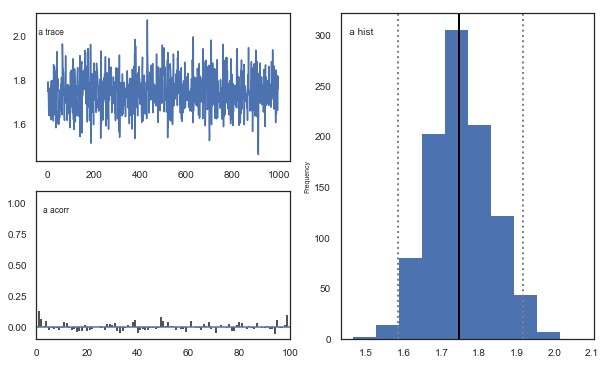

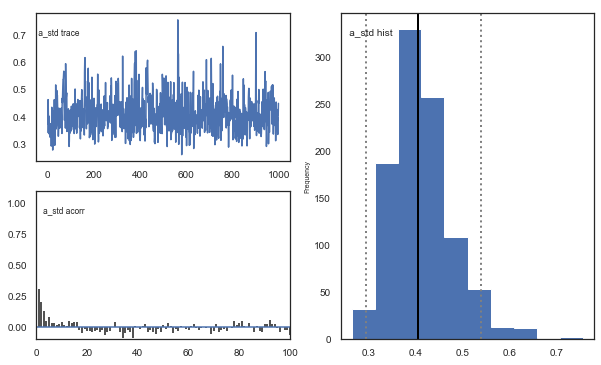

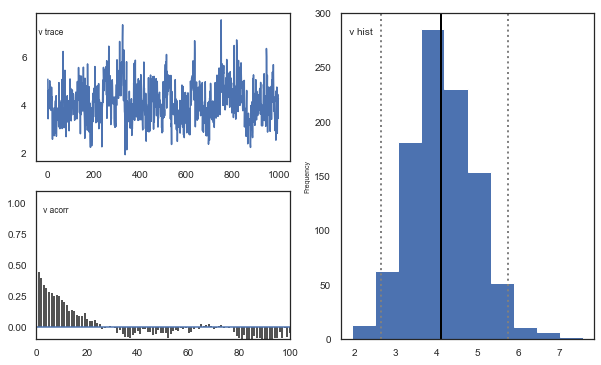

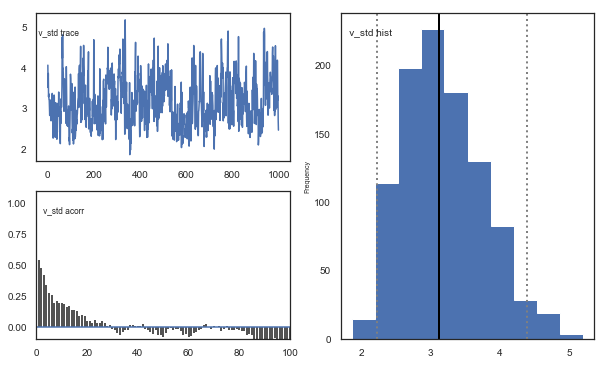

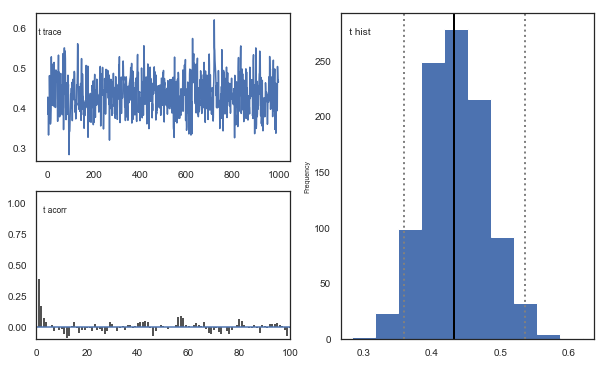

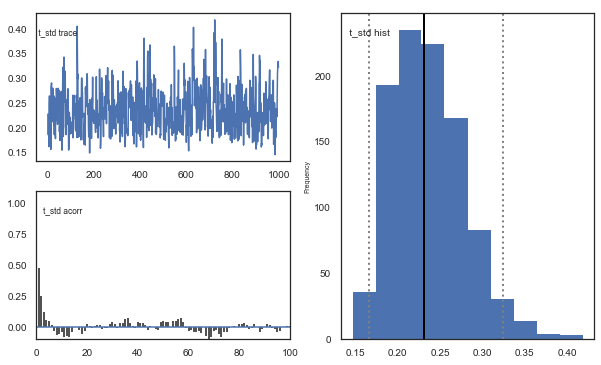

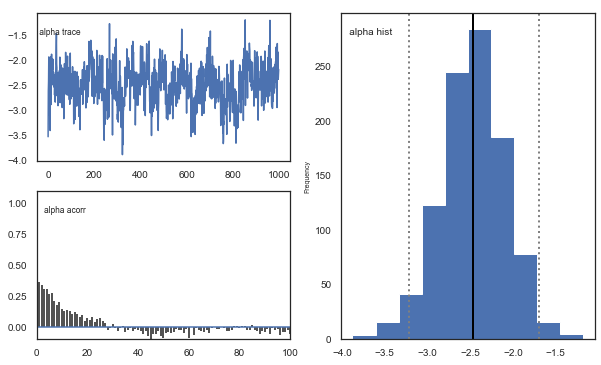

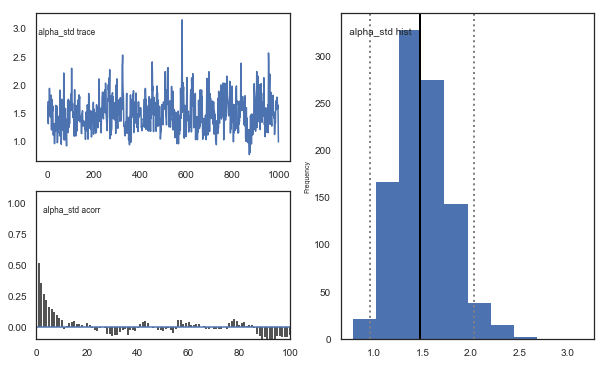

In [4]:
# plot the posteriors of parameters
m.plot_posteriors()

__Fig__. The mixing of the posterior distribution and autocorrelation looks ok.

### Convergence of chains
The Gelman-Rubin statistic is a test of whether the chains in the model converges. The Gelman-Ruben statistic measures the degree of variation between and within chains. Values close to 1 indicate convergence and that there is small variation between chains, i.e. that they end up as the same distribution across chains. A common heuristic is to assume convergence if all values are below 1.1. To run this you need to run multiple models, combine them and perform the Gelman-Rubin statistic:

In [5]:
# estimate convergence
from kabuki.analyze import gelman_rubin

models = []
for i in range(3):
    m = hddm.HDDMrl(data=data)
    m.sample(1500, burn=500, dbname="traces.db", db="pickle")
    models.append(m)

gelman_rubin(models)

 [-----------------100%-----------------] 1500 of 1500 complete in 148.3 sec

/Users/madslundpedersen/anaconda/envs/py36/lib/python3.6/site-packages/kabuki/analyze.py:148: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  samples[i,:] = model.nodes_db.ix[name, 'node'].trace()
/Users/madslundpedersen/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


{'a': 1.0032460874018214,
 'a_std': 1.0009841521872085,
 'a_subj.3': 1.0004396186849591,
 'a_subj.4': 0.9999534502455131,
 'a_subj.5': 1.003486683386713,
 'a_subj.6': 1.0019388857243001,
 'a_subj.8': 1.0011512646603846,
 'a_subj.12': 0.999566242847165,
 'a_subj.17': 0.9997315595714608,
 'a_subj.18': 1.007802746170568,
 'a_subj.19': 1.0006648642694451,
 'a_subj.20': 0.9997046168477743,
 'a_subj.22': 0.999761021617672,
 'a_subj.23': 0.999981103582067,
 'a_subj.24': 0.9999604239014099,
 'a_subj.26': 0.9999505203703547,
 'a_subj.33': 1.0000641985256977,
 'a_subj.34': 1.0019030857893532,
 'a_subj.35': 0.9995619813519606,
 'a_subj.36': 1.0009696684307878,
 'a_subj.39': 1.0030366187047326,
 'a_subj.42': 1.0004536365990904,
 'a_subj.50': 1.0009246525621893,
 'a_subj.52': 0.9998106391663311,
 'a_subj.56': 1.002833217938155,
 'a_subj.59': 1.0037497197540834,
 'a_subj.63': 0.9999025733097772,
 'a_subj.71': 1.0009484787096814,
 'a_subj.75': 1.0130098962514307,
 'a_subj.80': 0.9996362431035328,
 'v

In [6]:
np.max(list(gelman_rubin(models).values()))

1.0446533107136062

The model seems to have converged, i.e. the Gelman-Rubin statistic is below 1.1 for all parameters. It is important to always run this test, especially for more complex models ([as with separate learning rates for positive and negative prediction errors](#9.-Separate-learning-rates-for-positive-and-negative-prediction-errors)). So now we can combine these three models to get a better approximation of the posterior distribution.

In [7]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)

### Joint posterior distribution
Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what's usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. [Daw, 2011](https://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780199600434.001.0001/acprof-9780199600434-chapter-001)).

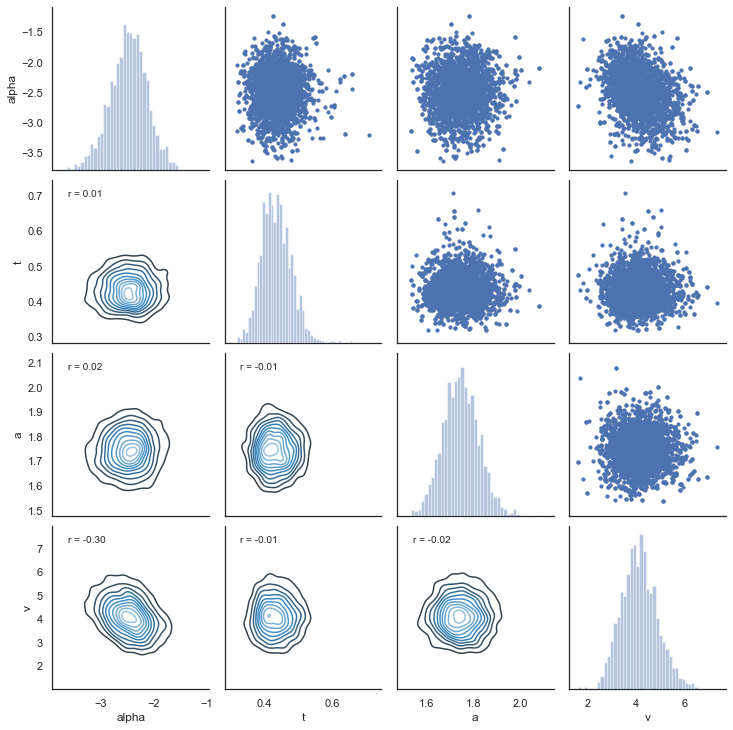

In [8]:
alpha, t, a, v = m.nodes_db.node[["alpha", "t", "a", "v"]]
samples = {"alpha": alpha.trace(), "t": t.trace(), "a": a.trace(), "v": v.trace()}
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(0.1, 0.9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig("matrix_plot.png")

## 7. Posterior predictive checks

An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

### extract traces
The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).

In [9]:
traces = m.get_traces()
traces.head()

,a,a_std,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.8,a_subj.12,a_subj.17,a_subj.18,...,alpha_subj.39,alpha_subj.42,alpha_subj.50,alpha_subj.52,alpha_subj.56,alpha_subj.59,alpha_subj.63,alpha_subj.71,alpha_subj.75,alpha_subj.80
0,1.663258,0.379335,1.999766,1.964781,1.501228,2.558870,2.134354,1.808065,1.428145,1.904139,...,-2.569240,-2.348125,-2.279293,-3.002542,-2.038603,-2.255088,-0.153830,-1.809325,-1.738580,-2.323516
1,1.623170,0.359708,1.912802,1.967012,1.462844,2.466133,2.347265,2.031387,1.476833,1.883079,...,-2.593007,-2.564579,-2.787299,-2.817155,0.128265,-2.358720,-0.709526,-1.876886,-1.428454,-3.140597
2,1.817655,0.312626,2.013651,1.870517,1.438784,2.332917,2.426746,2.079006,1.264283,1.939135,...,-3.187908,-2.566549,-3.341771,-3.206621,-0.724311,-2.446694,-1.133453,-2.153231,-1.589570,-2.702218
3,1.762559,0.573961,1.852805,1.920585,1.456088,2.437470,2.679242,2.099067,1.311264,1.902507,...,-2.045972,-2.466571,-3.093191,-3.204751,-3.220443,-2.381405,-1.060397,-1.521510,-1.892220,-2.902676
4,1.725824,0.472488,1.907957,1.954045,1.462033,2.394734,2.389626,1.928428,1.334218,1.790217,...,-2.035124,-2.679132,-3.821553,-3.372584,-1.139438,-2.372234,-0.895417,-1.900813,-2.196233,-3.063793


### simulating data
__Now that we have the traces the next step is to simulate data using the estimated parameters. The RLDDM includes a function to simulate data. Here's an example of how to use the simulation-function for RLDDM. This example explains how to generate data with binary outcomes. See [here](#11.-Probabilistic-binary-outcomes-vs.-normally-distributed-outcomes) for an example on simulating data with normally distributed outcomes. Inputs to function: <br>
a__ = decision threshold <br>
**t** = non-decision time <br>
__alpha__ = learning rate <br>
__pos_alpha__ = defaults to 0. if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate_ for negative prediction errors.  <br>
__scaler__ = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate <br>
__p_upper__ = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0 <br>
__p_lower__ = the probability of reward for the option represented by the lower boundary. <br>
__subjs__ = number of subjects to simulate data for. <br>
__split_by__ = define the condition which makes it easier to append data from different conditions. <br>
__size__ = number of trials per subject. <br>

In [10]:
hddm.generate.gen_rand_rlddm_data(
    a=1,
    t=0.3,
    alpha=0.2,
    scaler=2,
    p_upper=0.8,
    p_lower=0.2,
    subjs=1,
    split_by=0,
    size=10,
)

,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial
0,0.5000,0.50000,0.00000,1.0,0.770,1.0,0,0,1
1,0.6000,0.50000,0.20000,0.0,0.403,0.0,0,0,2
2,0.6000,0.40000,0.40000,0.0,0.612,0.0,0,0,3
3,0.6000,0.32000,0.56000,0.0,0.404,1.0,0,0,4
4,0.6000,0.45600,0.28800,1.0,0.564,1.0,0,0,5
5,0.6800,0.45600,0.44800,1.0,0.416,1.0,0,0,6
6,0.7440,0.45600,0.57600,0.0,0.430,0.0,0,0,7
7,0.7440,0.36480,0.75840,0.0,0.409,0.0,0,0,8
8,0.7440,0.29184,0.90432,1.0,0.361,1.0,0,0,9
9,0.7952,0.29184,1.00672,1.0,0.537,0.0,0,0,10


__How to interpret columns in the resulting dataframe__ <br>
__q_up__ = expected reward for option represented by upper boundary <br>
__q_low__ = expected reward for option represented by lower boundary <br>
__sim_drift__ = the drift rate for each trial calculated as: (q_up-q_low)*scaler <br>
__response__ = simulated choice <br>
__rt__ = simulated response time <br>
__feedback__ = observed feedback for chosen option <br>
__subj_idx__ = subject id (starts at 0) <br>
__split_by__ = condition as integer <br>
__trial__ = current trial (starts at 1) <br>

### Simulate data with estimated parameter values and compare to observed data
Now that we know how to extract traces and simulate data we can combine this to create a dataset similar to our observed data. This process is currently not automated but the following is an example code using the dataset we analyzed above.

In [11]:
from tqdm import tqdm  # progress tracker

# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
data["samp"] = 0
# load traces
traces = m.get_traces()
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 51)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0] - 1)
    # loop through all subjects in observed data
    for s in data.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 0)].trial.unique()
        )
        size1 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 1)].trial.unique()
        )
        size2 = len(
            data[(data["subj_idx"] == s) & (data["split_by"] == 2)].trial.unique()
        )
        # set parameter values for simulation
        a = traces.loc[sample, "a_subj." + str(s)]
        t = traces.loc[sample, "t_subj." + str(s)]
        scaler = traces.loc[sample, "v_subj." + str(s)]
        alphaInv = traces.loc[sample, "alpha_subj." + str(s)]
        # take inverse logit of estimated alpha
        alpha = np.exp(alphaInv) / (1 + np.exp(alphaInv))
        # simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            size=size0,
            p_upper=0.8,
            p_lower=0.2,
            split_by=0,
        )
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            size=size1,
            p_upper=0.7,
            p_lower=0.3,
            split_by=1,
        )
        sim_data2 = hddm.generate.gen_rand_rlddm_data(
            a=a,
            t=t,
            scaler=scaler,
            alpha=alpha,
            size=size2,
            p_upper=0.6,
            p_lower=0.4,
            split_by=2,
        )
        # append the conditions
        sim_data0 = sim_data0.append([sim_data1, sim_data2], ignore_index=True)
        # assign subj_idx
        sim_data0["subj_idx"] = s
        # identify that these are simulated data
        sim_data0["type"] = "simulated"
        # identify the simulated data
        sim_data0["samp"] = i
        # append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)
# combine observed and simulated data
ppc_data = data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "samp"]
].copy()
ppc_data["type"] = "observed"
ppc_sdata = sim_data[
    ["subj_idx", "response", "split_by", "rt", "trial", "feedback", "type", "samp"]
].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv("ppc_data_tutorial.csv")

100%|██████████| 50/50 [31:09<00:00, 37.39s/it]
/Users/madslundpedersen/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### Plotting
Now that we have a dataframe with both observed and simulated data we can plot to see whether the simulated data are able to capture observed choice and reaction times. To capture the uncertainty in the simulated data we want to identify how much choice and reaction differs across the simulated data sets. A good measure of this is to calculate the highest posterior density/highest density interval for summary scores of the generated data. Below we calculate highest posterior density with an alpha set to 0.1, which means that we are describing the range of the 90% most likely values.

In [12]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

### Choice

In [13]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data["bin_trial"] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)
).astype("int64")
# calculate means for each sample
sums = (
    plot_ppc_data.groupby(["bin_trial", "split_by", "samp", "type"])
    .mean()
    .reset_index()
)
# calculate the overall mean response across samples
ppc_sim = sums.groupby(["bin_trial", "split_by", "type"]).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim["upper_hpd"] = 0
ppc_sim["lower_hpd"] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(
        sums.response[
            (sums["bin_trial"] == ppc_sim.bin_trial[i])
            & (sums["split_by"] == ppc_sim.split_by[i])
            & (sums["type"] == ppc_sim.type[i])
        ],
        alpha=0.1,
    )
    ppc_sim.loc[i, "upper_hpd"] = hdi[1]
    ppc_sim.loc[i, "lower_hpd"] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim["up_err"] = ppc_sim["upper_hpd"] - ppc_sim["response"]
ppc_sim["low_err"] = ppc_sim["response"] - ppc_sim["lower_hpd"]
ppc_sim["model"] = "RLDDM_single_learning"
ppc_sim.to_csv("ppc_choicedata_tutorial.csv")

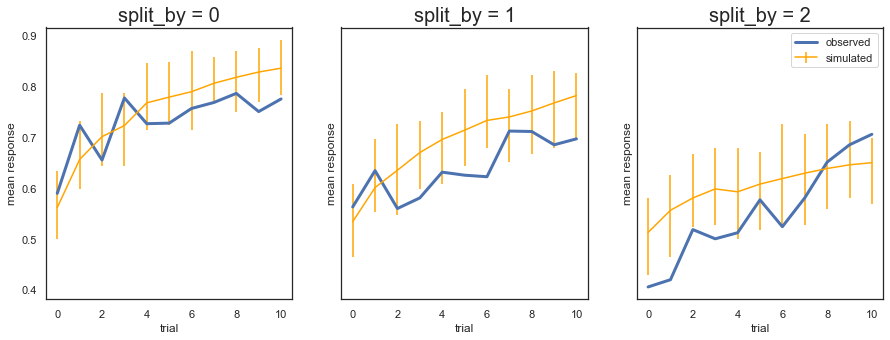

In [14]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, sharex=True, sharey=True)
for i in range(0, 3):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "simulated")]
    ax.errorbar(
        d.bin_trial,
        d.response,
        yerr=[d.low_err, d.up_err],
        label="simulated",
        color="orange",
    )
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == "observed")]
    ax.plot(d.bin_trial, d.response, linewidth=3, label="observed")
    ax.set_title("split_by = %i" % i, fontsize=20)
    ax.set_ylabel("mean response")
    ax.set_xlabel("trial")
plt.legend()
fig.savefig("PPCchoice.pdf")

__Fig.__ The plots display the rate of choosing the best option (response = 1) across learning and condition. The model generates data (orange) that closely follows the observed behavior (blue), with the exception of overpredicting performance early in the most difficult condition (split_by=2). Uncertainty in the generated data is captured by the 90% highest density interval of the means across simulated datasets.

### RT

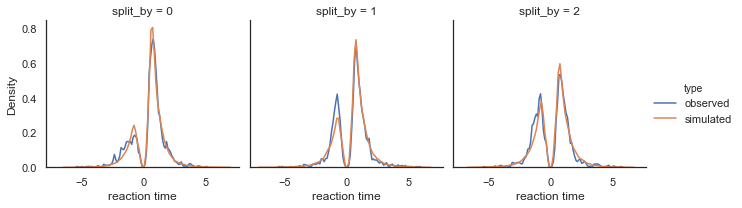

In [15]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data["reaction time"] = np.where(
    plot_ppc_data["response"] == 1, plot_ppc_data.rt, 0 - plot_ppc_data.rt
)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col="split_by", hue="type")
g.map(sns.kdeplot, "reaction time", bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig("PPCrt_dist.pdf")

__Fig.__ Density plots of observed and predicted reaction time across conditions. RTs for lower boundary choices (i.e. worst option choices) are set to be negative (0-RT) to be able to separate upper and lower bound responses.

## 8. Parameter recovery
To validate the RLDDM we ran a parameter recovery study to test to which degree the model can recover the parameter values used to simulate data. To do this we generated 81 synthetic datasets with 50 subjects performing 70 trials each. The 81 datasets were simulated using all combinations of three plausible parameter values for decision threshold, non-decision time, learning rate and the scaling parameter onto drift rate.

### Estimated values split by simulated vales 
We can plot simulated together with the estimated values to test the models ability to recover parameters, and to see if there are any values that are more difficult to recover than others.

In [16]:
param_recovery = hddm.load_csv("recovery_sim_est_rlddm.csv")

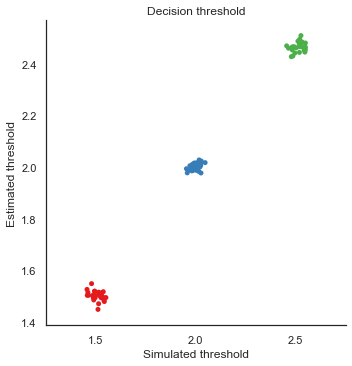

In [17]:
g = sns.catplot(x="a", y="e_a", data=param_recovery, palette="Set1")
g.set_axis_labels("Simulated threshold", "Estimated threshold")
plt.title("Decision threshold")
g.savefig("Threshold_recovery.pdf")

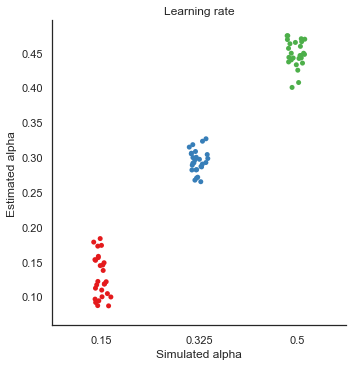

In [18]:
g = sns.catplot(x="alpha", y="e_alphaT", data=param_recovery, palette="Set1")
g.set_axis_labels("Simulated alpha", "Estimated alpha")
plt.title("Learning rate")
g.savefig("Alpha_recovery.pdf")

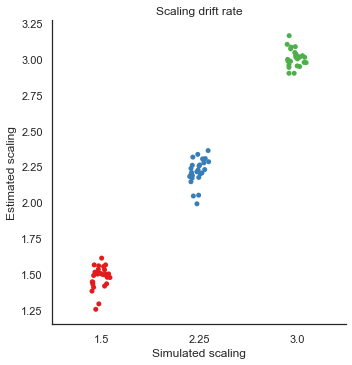

In [19]:
g = sns.catplot(x="scaler", y="e_v", data=param_recovery, palette="Set1")
g.set_axis_labels("Simulated scaling", "Estimated scaling")
plt.title("Scaling drift rate")
g.savefig("Scaler_recovery.pdf")

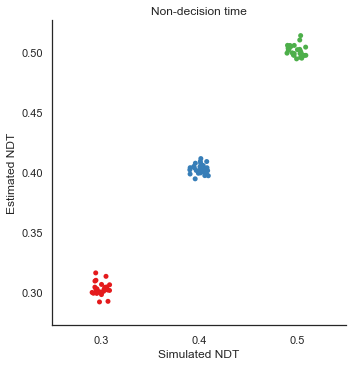

In [20]:
g = sns.catplot(x="t", y="e_t", data=param_recovery, palette="Set1")
g.set_axis_labels("Simulated NDT", "Estimated NDT")
plt.title("Non-decision time")
g.savefig("NDT_recovery.pdf")

__Fig.__ The correlation between simulated and estimated parameter values are high, which means recovery is good. There is somewhat worse recovery for the learning rate and scaling parameter, which makes sense given that they to a degree can explain the same variance (see below).

## 12. HDDMrlRegressor

As of version 0.7.6. HDDM includes a module for estimating the impact of continuous regressor onto RLDDM parameters. The module, called HDDMrlRegressor, works the same way as the HDDMRegressor for the normal DDM. The method allows estimation of the association of e.g. neural measures onto parameters. To illustrate the method we extend the function to generate rlddm_data by adding a normally distributed regressor and including a coefficient called 'neural'.Note that to run the HDDMrlRegressor you need to include alpha when specifying the model. For more information on how to set up regressor models look at the tutorial for HDDM.

In [78]:
# function to generate rlddm-data that adds a neural regressor to decision threshold
def gen_rand_reg_rlddm_data(
    a,
    t,
    scaler,
    alpha,
    neural,
    size=1,
    p_upper=1,
    p_lower=0,
    z=0.5,
    q_init=0.5,
    split_by=0,
    subjs=1,
):
    all_data = []
    n = size
    # set sd for variables to generate subject-parameters from group distribution
    sd_t = 0.02
    sd_a = 0.1
    sd_alpha = 0.1
    sd_v = 0.25
    # save parameter values as group-values
    tg = t
    ag = a
    alphag = alpha
    scalerg = scaler
    for s in range(0, subjs):
        t = (
            np.maximum(0.05, np.random.normal(loc=tg, scale=sd_t, size=1))
            if subjs > 1
            else tg
        )
        a = (
            np.maximum(0.05, np.random.normal(loc=ag, scale=sd_a, size=1))
            if subjs > 1
            else ag
        )
        alpha = (
            np.minimum(
                np.minimum(
                    np.maximum(0.001, np.random.normal(loc=alphag, scale=sd_a, size=1)),
                    alphag + alphag,
                ),
                1,
            )
            if subjs > 1
            else alphag
        )
        scaler = (
            np.random.normal(loc=scalerg, scale=sd_v, size=1) if subjs > 1 else scalerg
        )
        # create a normalized regressor that is combined with the neural coefficient to create trial-by-trial values for decision threshold
        neural_reg = np.random.normal(0, 1, size=n)
        q_up = np.tile([q_init], n)
        q_low = np.tile([q_init], n)
        response = np.tile([0.5], n)
        feedback = np.tile([0.5], n)
        rt = np.tile([0], n)
        rew_up = np.random.binomial(1, p_upper, n).astype(float)
        rew_low = np.random.binomial(1, p_lower, n).astype(float)
        sim_drift = np.tile([0], n)
        subj_idx = np.tile([s], n)
        d = {
            "q_up": q_up,
            "q_low": q_low,
            "sim_drift": sim_drift,
            "rew_up": rew_up,
            "rew_low": rew_low,
            "response": response,
            "rt": rt,
            "feedback": feedback,
            "subj_idx": subj_idx,
            "split_by": split_by,
            "trial": 1,
            "neural_reg": neural_reg,
        }
        df = pd.DataFrame(data=d)
        df = df[
            [
                "q_up",
                "q_low",
                "sim_drift",
                "rew_up",
                "rew_low",
                "response",
                "rt",
                "feedback",
                "subj_idx",
                "split_by",
                "trial",
                "neural_reg",
            ]
        ]
        # generate data trial-by-trial using the Intercept (a), regressor (neural_reg) and coefficient (neural) for decision threshold.
        data, params = hddm.generate.gen_rand_data(
            {
                "a": a + neural * df.loc[0, "neural_reg"],
                "t": t,
                "v": df.loc[0, "sim_drift"],
                "z": z,
            },
            subjs=1,
            size=1,
        )
        df.loc[0, "response"] = data.response[0]
        df.loc[0, "rt"] = data.rt[0]
        if data.response[0] == 1.0:
            df.loc[0, "feedback"] = df.loc[0, "rew_up"]
        else:
            df.loc[0, "feedback"] = df.loc[0, "rew_low"]

        for i in range(1, n):
            df.loc[i, "trial"] = i + 1
            df.loc[i, "q_up"] = (
                df.loc[i - 1, "q_up"] * (1 - df.loc[i - 1, "response"])
            ) + (
                (df.loc[i - 1, "response"])
                * (
                    df.loc[i - 1, "q_up"]
                    + (alpha * (df.loc[i - 1, "rew_up"] - df.loc[i - 1, "q_up"]))
                )
            )
            df.loc[i, "q_low"] = (
                df.loc[i - 1, "q_low"] * (df.loc[i - 1, "response"])
            ) + (
                (1 - df.loc[i - 1, "response"])
                * (
                    df.loc[i - 1, "q_low"]
                    + (alpha * (df.loc[i - 1, "rew_low"] - df.loc[i - 1, "q_low"]))
                )
            )
            df.loc[i, "sim_drift"] = (df.loc[i, "q_up"] - df.loc[i, "q_low"]) * (scaler)
            data, params = hddm.generate.gen_rand_data(
                {
                    "a": a + neural * df.loc[i, "neural_reg"],
                    "t": t,
                    "v": df.loc[i, "sim_drift"],
                    "z": z,
                },
                subjs=1,
                size=1,
            )
            df.loc[i, "response"] = data.response[0]
            df.loc[i, "rt"] = data.rt[0]
            if data.response[0] == 1.0:
                df.loc[i, "feedback"] = df.loc[i, "rew_up"]
            else:
                df.loc[i, "feedback"] = df.loc[i, "rew_low"]
        all_data.append(df)
    all_data = pd.concat(all_data, axis=0)
    all_data = all_data[
        [
            "q_up",
            "q_low",
            "sim_drift",
            "response",
            "rt",
            "feedback",
            "subj_idx",
            "split_by",
            "trial",
            "neural_reg",
        ]
    ]

    return all_data

In [79]:
# Create data with function defined above.
# This will create trial-by-trial values for decision threshold (a) by adding the coefficient neural (here set to 0.2)
# multiplied by a normalized regressor (neural_reg) to the 'Intercept' value of a (here set to 1)
data_neural = gen_rand_reg_rlddm_data(
    a=1,
    t=0.3,
    scaler=2,
    alpha=0.2,
    neural=0.2,
    size=100,
    p_upper=0.7,
    p_lower=0.3,
    subjs=25,
)
data_neural["q_init"] = 0.5
data_neural.head()

,q_up,q_low,sim_drift,response,rt,feedback,subj_idx,split_by,trial,neural_reg,q_init
0,0.500000,0.500000,0.000000,1.0,0.506025,1.0,0,0,1,-0.563624,0.5
1,0.655194,0.500000,0.321482,1.0,0.612025,1.0,0,0,2,-0.781290,0.5
2,0.762217,0.500000,0.543180,0.0,0.473025,1.0,0,0,3,1.264806,0.5
3,0.762217,0.655194,0.221698,0.0,0.667025,0.0,0,0,4,0.298274,0.5
4,0.762217,0.451830,0.642964,1.0,0.409025,1.0,0,0,5,0.229071,0.5


In [80]:
# run a regressor model estimating the impact of 'neural' on decision threshold a. This should estimate the coefficient a_neural_reg to be 0.2
# to run the HDDMrlRegressor you need to include alpha
m_reg = hddm.HDDMrlRegressor(
    data_neural, "a ~ neural_reg", include=["v", "a", "t", "alpha"]
)
m_reg.sample(1000, burn=250)
m_reg.print_stats()

Adding these covariates:
['a_Intercept', 'a_neural_reg']
 [-----------------100%-----------------] 1001 of 1000 complete in 687.8 sec                          mean         std       2.5q        25q        50q       75q      97.5q       mc err
v                      1.77982    0.179364    1.44742    1.65881    1.77016    1.8981    2.13252    0.0154737
v_std                 0.347709    0.156495   0.106553   0.223578   0.334912  0.456798   0.685135    0.0139315
v_subj.0               1.90511    0.349163    1.32363    1.67743    1.86487    2.0913    2.72363    0.0222543
v_subj.1               1.95427    0.331428    1.38104    1.72245    1.92206   2.15408    2.74285    0.0202816
v_subj.2               1.61025    0.356265   0.861761    1.36741    1.63258    1.8535      2.247    0.0207686
v_subj.3               1.74581     0.27481    1.24771    1.55051    1.72674   1.92711    2.35696    0.0147636
v_subj.4               1.86945     0.29564    1.34704    1.65746    1.85039   2.04593    2.56522 